In [1]:
import os
import sys
import getopt

import parse_genet
import vi

import importlib

import simulate
import torch
import matplotlib.pyplot as plt
import numpy as np

import pyro.distributions as dist

import scipy.stats

In [2]:
chrom = 22

param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}

## 'ref_dir' : "../ld/ldblk_1kg_eur", 
## 'bim_prefix' : "test_data/test",


In [10]:
## test the beta in sumstats
# import pandas as pd
# import numpy as np
sumstat = pd.read_csv('test_data/sumstats.txt', sep = '\t')
print(sumstat.BETA.mean(), sumstat.BETA.std())


-9.330000000000005e-05 0.012583713878063382


... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
... SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 208 iterations. Increasing num_particles to 2.
Done after 126 iterations. Increasing num_particles to 4.
Done after 111 iterations. Increasing num_particles to 8.


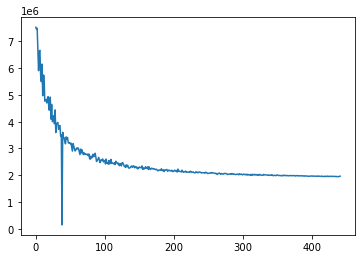

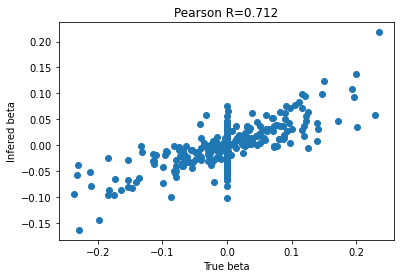

In [11]:
## testing only using 1000 SNPs in summary stats in chr22
if '1kg' in os.path.basename(param_dict['ref_dir']):
    ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
    ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

ref_df = ref_df[ref_df.CHR == chrom]
vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
vld_df = vld_df[vld_df.CHR == chrom]
sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas']) ## take the interception SNP of sumstat, ref_ld, validate df
ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)


#mcmc_gtb.mcmc(param_dict['a'], param_dict['b'], param_dict['phi'], sst_dict, param_dict['n_gwas'], ld_blk, blk_size, param_dict['n_iter'], param_dict['n_burnin'], param_dict['thin'], int(chrom), param_dict['out_dir'], param_dict['beta_std'], param_dict['seed'])

beta_true, beta_mrg, annotations = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict))
sst_dict["BETA"] = beta_mrg
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

importlib.reload(vi)
one = torch.tensor(1., device=device)
losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)

# observations: 
# collapsed >> uncollapsed (deleted uncollapsed code)
# phi_as_prior = False seems to give better results, but phi_as_prior = True gives more robust training (less noisy loss), probably because constraint on psi is more useful. 
# Does constrain_sigma help? I think constrain_psi does. 
# Seem to need desired_min_eig=1e-3 at least to avoid numerical issues. Could go lower if using float64 it seemed. 

plt.plot(losses); plt.show()

plt.scatter(beta_true, beta)
plt.xlabel("True beta")
plt.ylabel("Infered beta")
plt.title("Pearson R=%1.3f" % scipy.stats.pearsonr(beta_true,beta)[0] )

stats["annotation_weights"] # ideally should show large positive value for second entry, and close to 0 for third (noise)

# convert standardized beta to per-allele beta
if param_dict["beta_std"] == 'False':
    beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))
    
sst_dict["beta_shrunk"] = beta
#sst_dict.to_csv("beta_shrunk.tsv", sep = "\t")



In [ ]:

simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict)) 


In [84]:
ld_blk[1].shape ##(173,173)
blk_size ## [134, 173, 507, 177]
p ## the interception SNP of sumstat, ref_ld, validate df

ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)

[134, 173, 507, 177]

In [87]:
p

991

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/wightman_chr22.tsv ...
... 14014 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
... SVI ...
Degenerate LD mat (min eigenvalue=-9.351e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.456e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.087e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.423e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.136e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.357e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-5.320e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.546e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-3.650e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-6.476e-03), fixing to 1.000e-03
Degenerate LD mat (m

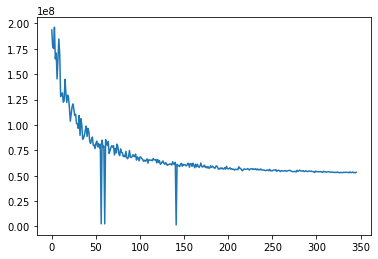

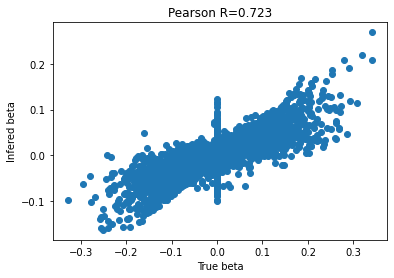

In [12]:
## using all chr22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/ADSP_qc_chr22", 
    'sst_file' : "test_data/wightman_chr22.tsv", 
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000
}

if '1kg' in os.path.basename(param_dict['ref_dir']):
    ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_1kg_hm3')
elif 'ukbb' in os.path.basename(param_dict['ref_dir']):
    ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

ref_df = ref_df[ref_df.CHR == chrom]
vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
vld_df = vld_df[vld_df.CHR == chrom]
sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)

#mcmc_gtb.mcmc(param_dict['a'], param_dict['b'], param_dict['phi'], sst_dict, param_dict['n_gwas'], ld_blk, blk_size, param_dict['n_iter'], param_dict['n_burnin'], param_dict['thin'], int(chrom), param_dict['out_dir'], param_dict['beta_std'], param_dict['seed'])

## here, simulation
beta_true, beta_mrg, annotations = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict))
sst_dict["BETA"] = beta_mrg
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

importlib.reload(vi)
one = torch.tensor(1., device=device)
losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = annotations, max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)

plt.plot(losses); plt.show()

plt.scatter(beta_true, beta)
plt.xlabel("True beta")
plt.ylabel("Infered beta")
plt.title("Pearson R=%1.3f" % scipy.stats.pearsonr(beta_true,beta)[0] )

stats["annotation_weights"] # ideally should show large positive value for second entry, and close to 0 for third (noise)

# convert standardized beta to per-allele beta
if param_dict["beta_std"] == 'False':
    beta /= np.sqrt(2.0*sst_dict['MAF']*(1.0-sst_dict['MAF']))
    
sst_dict["beta_shrunk"] = beta
#sst_dict.to_csv("beta_shrunk.tsv", sep = "\t")




In [20]:
loss_np = np.array(losses)
indices = np.where(loss_np < 1e7)[0]

# Print values and their corresponding indices
for index in indices:
    print(f"Value {loss_np[index]} at index {index}")

Value 2530739.7761394978 at index 56
Value 2474466.6801837683 at index 60
Value 1457925.2138929367 at index 141


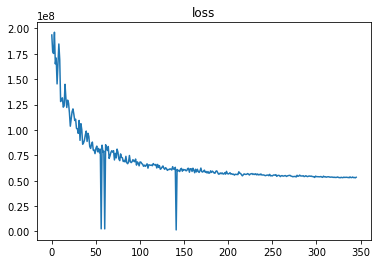

In [22]:
plt.plot(losses); plt.title('loss');plt.show()